In [1]:
from requests import get
from json import loads
import time
import pandas as pd
from tqdm.notebook import trange, tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mtg_toolbox as mtg_tools

In [3]:
card_request = "Propeller Pioneer" # carte de base

#card_request = "Agadeem's Awakening" #mdfc land/spell
#card_request = "Jadzi, Oracle of Arcavios" #mdfc spell/spell
#card_request = "Bonecrusher Giant / Stomp" #adventure
#card_request = "claim-fame" #split card
#card_request = "Delver of Secrets" #double-faced spell/spell (free)
#card_request = "Search for Azcanta" #double faced spell/land (free)
#card_request = "Arlinn, the Pack's Hope" #double faced daybound (free)
#card_request = "Behold the Unspeakable" #saga (free)
#card_request = "Hostile Hostel" #double faced land/spell (free)
#card_request = "Malevolent Hermit" #double face disturb (with mana cost) 
#card_request = "Akki Lavarunner" #flip card

#card_request = "Bruna, the Fading Light" #meld => 1 seul face

In [4]:
card = loads(get(f"https://api.scryfall.com/cards/named?fuzzy={card_request}").text)

In [5]:
#card["card_faces"]

In [6]:
card["cmc"]

4.0

In [7]:
card.keys()

dict_keys(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id', 'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang', 'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image', 'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power', 'toughness', 'colors', 'color_identity', 'keywords', 'all_parts', 'legalities', 'games', 'reserved', 'foil', 'nonfoil', 'finishes', 'oversized', 'promo', 'reprint', 'variation', 'set_id', 'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri', 'scryfall_set_uri', 'rulings_uri', 'prints_search_uri', 'collector_number', 'digital', 'rarity', 'flavor_text', 'card_back_id', 'artist', 'artist_ids', 'illustration_id', 'border_color', 'frame', 'full_art', 'textless', 'booster', 'story_spotlight', 'edhrec_rank', 'prices', 'related_uris', 'purchase_uris'])

In [8]:
card['keywords']

['Flying', 'Fabricate']

In [9]:
card["oracle_text"]

'Flying\nFabricate 1 (When this creature enters the battlefield, put a +1/+1 counter on it or create a 1/1 colorless Servo artifact creature token.)'

In [10]:
"card_faces" in card.keys()

False

In [11]:
time.sleep(0.01)

### Parse deck

In [21]:
#file = "Listes/double_face_list.txt" 
#file = "Listes/double_face_list_only_2_cards.txt"
file = "Listes/supertypes_types_subtypes.txt"
with open(file) as f:
    lines = f.readlines()

In [13]:
decklist = {"nom":[],"cmc":[],"text":[],"mana_cost":[],"type":[],"carte_id":[], "is_dfc":[], "color_identity" :[]}
card_number = 0
for l in tqdm(lines):
    line = l.split("\n")[0]
    nb_card = int(line[0])
    card = line[2:]
    card = loads(get(f"https://api.scryfall.com/cards/named?fuzzy={card}").text)
    for _ in range(nb_card):
        if "card_faces" in card.keys() :
            for face in card["card_faces"] :
                try:
                    decklist["nom"].append(face["name"])
                    decklist["cmc"].append(mtg_tools.compute_cmc(face["mana_cost"]))
                    decklist["text"].append(face["oracle_text"])
                    decklist["mana_cost"].append(face["mana_cost"])
                    decklist["type"].append(face["type_line"])
                    decklist["carte_id"].append(card_number)
                    decklist["is_dfc"].append(True)
                    decklist["color_identity"].append(card["color_identity"])
                except KeyError:
                        #TODO EDGE CASE: treat double face cards
                        print("error on : ", face["name"])
        else :
            try:
                decklist["nom"].append(card["name"])
                decklist["cmc"].append(card["cmc"])
                decklist["text"].append(card["oracle_text"])
                decklist["mana_cost"].append(card["mana_cost"])
                decklist["type"].append(card["type_line"])
                decklist["carte_id"].append(card_number)
                decklist["is_dfc"].append(False)
                decklist["color_identity"].append(card["color_identity"])
            except KeyError:
                #TODO EDGE CASE: treat double face cards
                print("error on : ", card["name"])
    time.sleep(0.01)
    card_number += 1

  0%|          | 0/13 [00:00<?, ?it/s]

In [22]:
relevant_fields={"nom": "name", 
                "cmc": "cmc",
                "real_cmc": "real_cmc",
                "text": "oracle_text",
                "mana_cost": "mana_cost",
                "type_line": "type_line",
                "supertype": "supertype",
                "type": "type",
                "subtypes": "subtypes",
                "carte_id":"carte_id",
                "is_dfc":"is_dfc",
                "colors":"colors",
                "color_identity": "color_identity",
                "power": "power",
                "toughness": "toughness",
                "keywords": "keywords"}
decklist = {k: [] for k in relevant_fields.keys()}
print(decklist)
card_number = 0
for l in tqdm(lines):
    line = l.split("\n")[0]
    nb_card = int(line[0])
    card = line[2:]
    card = loads(get(f"https://api.scryfall.com/cards/named?fuzzy={card}").text)
    for _ in range(nb_card):
        card_faces = []
        if "card_faces" in card.keys() :
            for face in card["card_faces"] :
                card_faces.append(face)
        else :
            card_faces.append(card)
        for card_face in card_faces :
            for field in relevant_fields :
                #generic cases is face or card
                if relevant_fields[field] in card_face.keys() :
                    decklist[field].append(card_face[relevant_fields[field]])
                elif relevant_fields[field] in card.keys() :
                    decklist[field].append(card[relevant_fields[field]])
                else :
                    #specific cases
                    if field == "is_dfc" :
                        is_dfc = "card_faces" in card.keys()
                        decklist[field].append(is_dfc)
                    elif field == "carte_id" :
                        decklist[field].append(card_number)
                    elif field == "power" or field == "toughness" :
                        #non creatures cards have no power/thoughness field
                        decklist[field].append('')
                    elif field == "real_cmc" :
                        decklist[field].append(mtg_tools.compute_cmc(card_face["mana_cost"]))
                    elif field == "supertype":
                        cardtype = mtg_tools.Card_Type(card_face["type_line"])
                        decklist[field].append(cardtype.supertypes)
                    elif field == "type":
                        cardtype = mtg_tools.Card_Type(card_face["type_line"])
                        decklist[field].append(cardtype.card_types)
                    elif field == "subtypes":
                        cardtype = mtg_tools.Card_Type(card_face["type_line"])
                        decklist[field].append(cardtype.subtypes)
                        
    time.sleep(0.01)
    card_number += 1

{'nom': [], 'cmc': [], 'real_cmc': [], 'text': [], 'mana_cost': [], 'type_line': [], 'supertype': [], 'type': [], 'subtypes': [], 'carte_id': [], 'is_dfc': [], 'colors': [], 'color_identity': [], 'power': [], 'toughness': [], 'keywords': []}


  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
#print(decklist)

In [24]:
deck_df = pd.DataFrame(decklist)

In [25]:
deck_df

,nom,cmc,real_cmc,text,mana_cost,type_line,supertype,type,subtypes,carte_id,is_dfc,colors,color_identity,power,toughness,keywords
0,Dark Depths,0.0,0,Dark Depths enters the battlefield with ten ic...,,Legendary Snow Land,"[Legendary, Snow]",[Land],[],0,False,[],[],,,[]
1,"Narfi, Betrayer King",5.0,5,Other snow and Zombie creatures you control ge...,{3}{U}{B},Legendary Snow Creature — Zombie Wizard,"[Legendary, Snow]",[Creature],"[Zombie, Wizard]",1,False,"[B, U]","[B, U]",4,3,[]
2,"Codie, Vociferous Codex",3.0,3,"You can't cast permanent spells.\n{4}, {T}: Ad...",{3},Legendary Artifact Creature — Construct,[Legendary],"[Artifact, Creature]",[Construct],2,False,[],"[B, G, R, U, W]",1,4,[]
3,Bitterblossom,2.0,2,"At the beginning of your upkeep, you lose 1 li...",{1}{B},Tribal Enchantment — Faerie,[],"[Tribal, Enchantment]",[Faerie],3,False,[B],[B],,,[]
4,Academy Manufactor,3.0,3,"If you would create a Clue, Food, or Treasure ...",{3},Artifact Creature — Assembly-Worker,[],"[Artifact, Creature]",[Assembly-Worker],4,False,[],[],1,3,[]


In [18]:
cmc = []
for i in range(len(deck_df)):
    if "Land" in deck_df["type"].iloc[i]:
        pass
    elif "NA" in deck_df["type"].iloc[i]:
        pass
    else:
        cmc.append(int(deck_df["cmc"].iloc[i]))

(array([1., 3., 3., 5., 0., 4., 2., 0., 0., 2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

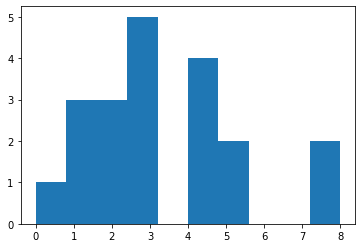

In [19]:
plt.hist(cmc)

<AxesSubplot:ylabel='Count'>

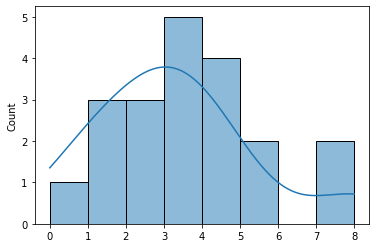

In [20]:
sns.histplot(data=cmc, kde=True, binwidth=1)